In [1]:
import sys
sys.path.insert(0, "/home/tumay/code/data-context-and-setup")

# Siparişler - `review_score` Çok Değişkenli Regresyonu

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

⚠️ Devam etmeden önce:
* 💾 Önceki ünitenin Siparişler çözümünü indirin
* 👥 `order_solution.py`'nin içeriğini `olist/order.py` dosyasına kopyalayıp yapıştırın

⚠️ `olist` havuzunuzda `order.py` dosyasındaki kod değişikliklerini commit etmeyi unutmayın!

👇 Öncelikle `orders` veri setini içeri aktarın

In [4]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

Önceki analizimizi hatırlayalım:

Aşağıdaki 👇 korelasyon matrisi üzerinden, `review_score`'un çoğunlukla iki özellik ile ilişkili olduğunu görebiliriz: `wait_time` ve `delay_vs_expected`. Ancak, bu iki özellik de birbirleriyle yüksek oranda ilişkilidirler.

Bu alıştırmada, bir özelliğin etkisini ayırt etmek için `statsmodels` kullanacağız, **diğer özellikleri sabit tutarak**.

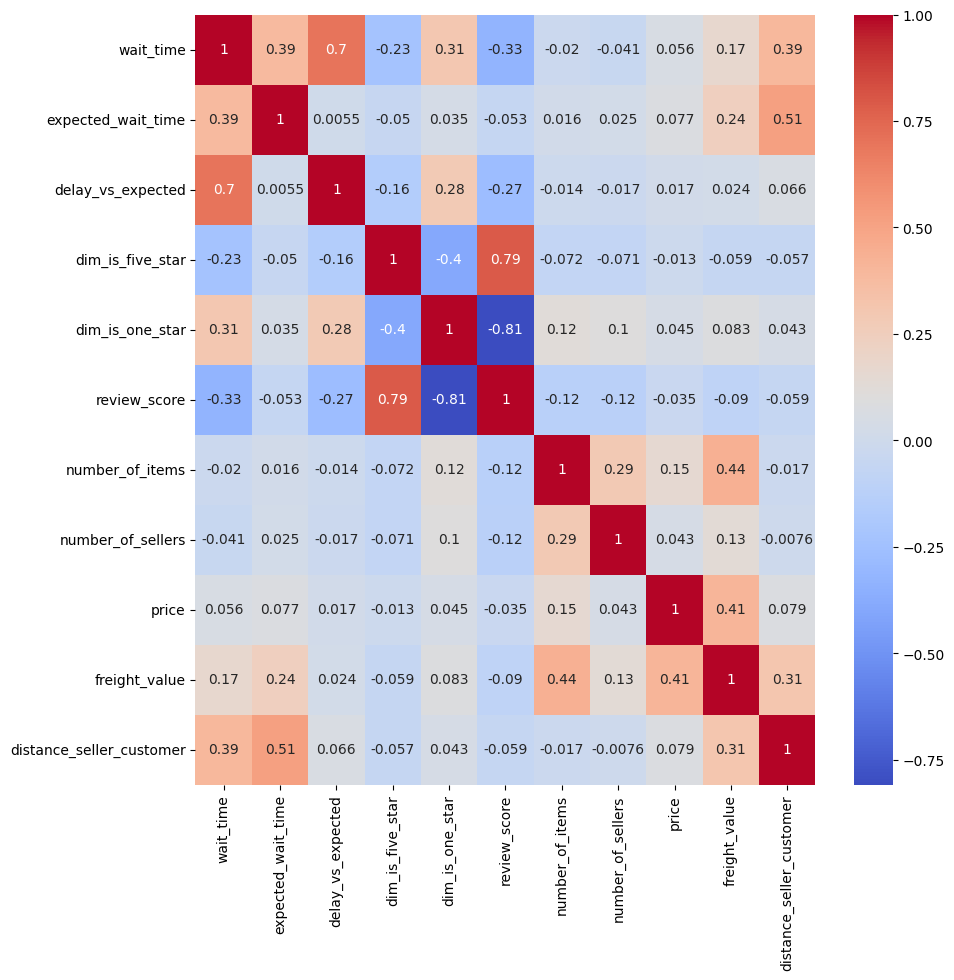

In [5]:
plt.figure(figsize = (10, 10))

sns.heatmap(
    orders.corr(numeric_only=True),
    cmap='coolwarm',
    annot=True,
    annot_kws={"size": 10}
);

In [6]:
orders[["wait_time", "delay_vs_expected"]].corr()

,wait_time,delay_vs_expected
wait_time,1.000000,0.702597
delay_vs_expected,0.702597,1.000000


## 1 - Tek Değişkenli Regresyon

❓ [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) ile `statsmodels.formula.api` kullanarak hızlı bir şekilde şunları oluşturun:
 - `model1`: `review_score`'un `wait_time` üzerinde ols regresyonu
 - `model2`: `review_score`'un `delay_vs_expected` üzerinde ols regresyonu

Her biri için `summary` tablosunu yazdırın ve sonuçları yorumlayin:
- Bu sonuçların seaborn regplot sonuçları ile nasıl eşleştiğini anladığınızdan emin olun
- Regresyon performans metriği `R-squared`, `individual regression coefficients`, `t-values`, `p-values` ve `95% confidence intervals`'ı okuyun

***Model 1***:

In [8]:
import statsmodels.formula.api as smf

model1 = smf.ols('review_score ~ wait_time', data=orders).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Fri, 26 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:43:45   Log-Likelihood:            -1.5441e+05
No. Observations:               95872   AIC:                         3.088e+05
Df Residuals:                   95870   BIC:                         3.089e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7236      0.006    727.904      0.0

## Model 1 – Tek Değişkenli Doğrusal Regresyon  
**(review_score ~ wait_time)**

Bu modelde amacımız, siparişin teslim edilmesi için geçen sürenin (`wait_time`) müşteri değerlendirme puanı (`review_score`) üzerindeki etkisini incelemektir.  
Bu amaçla `statsmodels` kullanılarak basit bir doğrusal regresyon modeli kurulmuştur.

---

### Modelin Genel Yapısı

Model aşağıdaki ilişkiyi tahmin etmektedir:

\[
review\_score = \beta_0 + \beta_1 \cdot wait\_time
\]

- **Bağımlı değişken:** `review_score`  
- **Bağımsız değişken:** `wait_time`  

---

### Temel Bulgular

#### 📌 Wait Time Katsayısı (coef)

- `wait_time` katsayısı: **-0.045**
- Bu değer şunu ifade eder:

> Teslim süresi 1 gün arttığında, ortalama müşteri puanı yaklaşık **0.045 puan düşmektedir**.

Örneğin:
- 10 günlük ek bekleme ≈ **0.45 puan düşüş**
- 20 günlük ek bekleme ≈ **1 puana yakın düşüş**

Bu sonuç, teslim süresinin müşteri memnuniyeti üzerinde **olumsuz bir etkisi** olduğunu göstermektedir.

---

#### 📌 İstatistiksel Anlamlılık (p-value)

- `wait_time` için p-value ≈ **0.000**

Bu da şu anlama gelir:
- Gözlenen ilişkinin tesadüfen ortaya çıkmış olma ihtimali yok denecek kadar azdır.
- Sonuç **istatistiksel olarak anlamlıdır**.

---

#### 📌 Güven Aralığı (Confidence Interval)

- %95 güven aralığı: **[-0.046, -0.045]**

Bu aralık:
- Etkinin kesin olarak **negatif** olduğunu,
- Katsayının işaretinin değişme ihtimalinin bulunmadığını göstermektedir.

---

#### 📌 R-squared Değeri

- **R-squared = 0.112**

Bu değer şu şekilde yorumlanabilir:
- Teslim süresi (`wait_time`), müşteri puanındaki değişimin yaklaşık **%11.2’sini** açıklamaktadır.
- Bu oran düşük görünse de, müşteri memnuniyetinin çok sayıda faktörden etkilendiği düşünüldüğünde **gerçekçi ve beklenen bir sonuçtur**.

---

### Modelin Yorumu ve Sınırları

- Teslim süresi müşteri puanı üzerinde **anlamlı ve negatif** bir etkiye sahiptir.
- Ancak bu model:
  - Müşteri puanını etkileyen **tek faktörün** teslim süresi olduğunu iddia etmez.
  - Ürün kalitesi, satıcı davranışı, fiyat, beklenti gibi diğer faktörleri kapsamaz.

Dolayısıyla bu model, **nedensellik değil ilişki** göstermektedir.

---

### İş Perspektifinden Özet

> Teslim süresi uzadıkça müşteri memnuniyeti anlamlı biçimde düşmektedir.  
> Özellikle uzun gecikmeler, müşteri puanlarında ciddi kayıplara yol açabilmektedir.  
> Bu nedenle teslimat performansı, müşteri deneyimini iyileştirmek için kritik bir faktördür.

---

### Sonraki Adım

Bir sonraki aşamada, `wait_time` ve `delay_vs_expected` değişkenleri **aynı anda** modele dahil edilerek,
her bir değişkenin diğerini sabit tutarak müşteri puanı üzerindeki **bağımsız etkisi** analiz edilecektir.


In [12]:
m1 = smf.ols("review_score ~ wait_time", data=orders).fit()
m1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Fri, 26 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:51:03   Log-Likelihood:            -1.5441e+05
No. Observations:               95872   AIC:                         3.088e+05
Df Residuals:                   95870   BIC:                         3.089e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7236      0.006    727.904      0.000       4.711       4.736
wait_time     -0.0454      0.000   -109.730      0.000      -0.046      -0.045
==============================================================================
Omnibus:                    19552.934   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35454.407
Skew:                          -1.300   Prob(JB):                         0.00
Kurtosis:                       4.453   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Model 2***:

In [13]:
import statsmodels.formula.api as smf

model2 = smf.ols('review_score ~ delay_vs_expected', data=orders).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7681.
Date:                Fri, 26 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:51:03   Log-Likelihood:            -1.5639e+05
No. Observations:               95872   AIC:                         3.128e+05
Df Residuals:                   95870   BIC:                         3.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2121      0.00

## Model 2 – Tek Değişkenli Doğrusal Regresyon  
**(review_score ~ delay_vs_expected)**

Bu modelde amacımız, siparişin **beklenen teslim tarihine göre gecikmesinin**
(`delay_vs_expected`) müşteri değerlendirme puanı (`review_score`) üzerindeki etkisini incelemektir.

---

### Modelin Yapısı

Model aşağıdaki ilişkiyi tahmin etmektedir:

\[
review\_score = \beta_0 + \beta_1 \cdot delay\_vs\_expected
\]

- **Bağımlı değişken:** `review_score`
- **Bağımsız değişken:** `delay_vs_expected`

---

### Temel Bulgular

#### 📉 Delay Katsayısı (coef)

- `delay_vs_expected` katsayısı: **-0.075**
- Bu sonuç şu anlama gelir:

> Sipariş, beklenen teslim tarihinden **1 gün daha geç teslim edildiğinde**,  
> müşteri puanı ortalama olarak **0.075 puan düşmektedir**.

Bu etki, sadece bekleme süresinden daha güçlü görünmektedir.

---

#### 📌 İstatistiksel Anlamlılık

- p-value ≈ **0.000**
- Sonuç **istatistiksel olarak anlamlıdır**.
- Gözlenen ilişkinin rastlantı olma ihtimali yok denecek kadar azdır.

---

#### 📊 R-squared Değeri

- **R² = 0.074**

Bu değer şunu ifade eder:
- Gecikme (`delay_vs_expected`), müşteri puanındaki değişimin yaklaşık **%7.4’ünü** açıklamaktadır.
- Müşteri memnuniyetinin birçok faktörden etkilendiği düşünülürse, bu oran makuldür.

---

### Modelin Yorumu

- Siparişin **beklenen tarihten sonra teslim edilmesi**, müşteri memnuniyetini ciddi biçimde düşürmektedir.
- Müşteriler uzun teslim süresine sabırlı olabilir, ancak **“gecikme” algısı** daha olumsuz bir etki yaratmaktadır.

---

### İş Perspektifinden Özet

> Teslimatın geç yapılması, sadece uzun sürmesinden daha olumsuz algılanmaktadır.  
> Beklenen tarihin kaçırılması, müşteri puanlarını daha hızlı düşürmektedir.

---

### Sonraki Adım

Bir sonraki aşamada:
- `wait_time` ve `delay_vs_expected` değişkenleri **aynı modelde birlikte** ele alınacak,
- Her bir değişkenin, diğeri sabit tutulduğunda **bağımsız etkisi** incelenecektir.


## 2 - Çok Değişkenli Regresyon

❓ Siparişe bir gün `delay_vs_expected` eklemenin `review_score` üzerindeki etkisi nedir, **`wait_time` sabit tutarak**? İki özellikten hangisi düşük `review_score` için en açıklayıcıdır?

Bu amaçla, `wait_time` ve `delay_vs_expected`'in özellikler (bağımsız değişkenler) olduğu ve `review_score`'un hedef (bağımlı değişken) olduğu bir OLS modeli `model3`'ü çalıştırın

***Model 3***:

In [11]:
model3 = smf.ols('review_score ~ wait_time + delay_vs_expected', data=orders).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6191.
Date:                Fri, 26 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:45:35   Log-Likelihood:            -1.5426e+05
No. Observations:               95872   AIC:                         3.085e+05
Df Residuals:                   95869   BIC:                         3.086e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6502      0.00

----
👉 Çok değişkenli regresyon, bir özelliğin etkisini izole etmek ve diğer özelliklerin etkisini kontrol etmek için bize izin verir. Bu yeni katsayılara **`kısmi korelasyon katsayıları`** denir. 

❓ Yukarıda *seaborn* ile hesaplanan **basit regresyon** katsayıları ile fark görebilir misiniz? 

❓ `wait_time` ve `delay_vs_expected` için göreceli eğimler hakkında ne söyleyebilirsiniz?

<details>
    <summary>- 💡 Solution 💡-</summary>

- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0205 [0.023 - 0.018] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0383 [0.039 - 0.037] points

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`! This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors

---
❌ R-squared oldukça düşük: review_score varyasyonlarının en fazla %12'si `wait_time` ve `delay_vs_expected`'in birleşik varyasyonları tarafından açıklanır.

✅ Doğrusal regresyonun açıklanabilirliğini iyileştirmek için regresyonumuza daha fazla özellik eklemeyi deneyelim.

Sonraki adımlarda `orders` veri setinden daha fazla özellik içeren yeni bir OLS `model4` oluşturacağız. Adım adım size rehberlik edeceğiz.

📝 <u>Not</u>: bir **`Çok Değişkenli Doğrusal Regresyon`** aynı zamanda **`Ordinary Least Squares`** yöntemi olarak da adlandırılır çünkü bu modelde **`MSE Ortalama Kare Hatalar`**'ı minimize etmek istiyoruz

***Model 4***:

❓ Hangi özellikleri göz önünde almak istersiniz?

👉 Bu özelliklerle bir `features` DataFrame oluşturun.

- ⚠️ **veri sızıntısı** oluşturmayın: `review_score`'tan doğrudan türetilen özellikleri eklemeyin
- ⚠️ Birbirleriyle mükemmel bir şekilde ilişkili olan iki özellik eklemeyin

In [14]:
features = orders[[
    "wait_time",
    "delay_vs_expected",
    "number_of_items",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]]

Sonra, özellikleri "standardize" edeceğiz.

**Bu ne anlama gelir?**

⚖️  Her özellik $X_i$'yi ilgili z-score'una $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ dönüştüreceğiz.

**Neden?**

Bir `çok değişkenli doğrusal regresyon`'da, her özelliğin hedef üzerindeki etkisini ölçmeye çalışıyoruz.
    
⚠️ Ölçek etkileri nedeniyle, bazı özellikler yanlışlıkla diğerlerinden daha önemli olarak görülecektir
    
> Örneğin: "yatak odası sayısı" özelliği 1 ile 5 arasında ve "yüzey" özelliği 20 ile 200 m² arasında ise, bu iki özelliğin aralıkları oldukça farklıdır...

Bu nedenle kısmi regresyon katsayıları $\beta_i$'yi birlikte karşılaştırabilmek için standardize ederiz. Aksi takdirde, $\beta_i$ aynı boyuta sahip olmayacak, yani elmalar (örn. "gün başına review-yıldızlar") ile portakalları (örn. "BRL başına review-yıldızlar") karşılaştırmış olacaksınız!

📅 Makine Öğrenmesi Algoritmalarını keşfettiğimizde, herhangi bir hedefi tahmin etmeye çalışmadan önce bazı ölçekleme işlemleri gerçekleştirmemiz gerekecektir.

👉  Özelliklerinizi standardize edin:

1. `features` DataFrame'inizden başlayın
1. `mean`'i çıkarın
1. Standart sapma `std`'ye bölün.
1. Sonucu `orders_standardized` değişkenine kaydedin.
1. Son olarak, `orders['review_score']` sütununu `orders_standardized`'e kopyalayın.

2. ve 3. adımları basit bir matematiksel işlem olarak yazabilirsiniz, hatta DataFrames ile de. Pandas bunu anlamak için yeterince akıllıdır.

<details>
  <summary><i>İpucu</i></summary>

  ```python
  features - features.mean() / features.std()
  ```

</details>

👉 `model4`'ü oluşturun ve eğitin.

In [15]:
orders_standardized = (features - features.mean()) / features.std()
orders_standardized['review_score'] = orders['review_score']
orders_standardized

,wait_time,delay_vs_expected,number_of_items,number_of_sellers,price,freight_value,distance_seller_customer,review_score
0,-0.431192,-0.161781,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475,4
1,0.134174,-0.161781,-0.264595,-0.112544,-0.086640,0.000467,0.429743,4
2,-0.329907,-0.161781,-0.264595,-0.112544,0.111748,-0.164053,-0.145495,5
3,0.073540,-0.161781,-0.264595,-0.112544,-0.441525,0.206815,2.054621,5
4,-1.019535,-0.161781,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115,5
...,...,...,...,...,...,...,...,...
95875,-0.454309,-0.161781,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033,5
95876,1.023841,-0.161781,-0.264595,-0.112544,0.183977,-0.123156,-0.212797,4
95877,1.305780,-0.161781,-0.264595,-0.112544,0.333684,1.964490,0.617630,5
95878,0.483664,-0.161781,1.601605,-0.112544,1.075186,2.715522,-0.387558,2


---
❓ En önemli özellikler nelerdir? (onları iyi görselleştirmek için `.plot(kind='barh')` ile bir çubuk grafik yapın)
- Genel regresyon performansı nasıl değişti?
- Bu regresyon istatistiksel olarak anlamlı mıdır?

In [16]:
formula = "review_score ~ " + ' + '.join(features.columns)
formula

'review_score ~ wait_time + delay_vs_expected + number_of_items + number_of_sellers + price + freight_value + distance_seller_customer'

<details>
    <summary>- 💡 Açıklamalar 💡 -</summary>
    

- `wait_time` en büyük açıklayıcı değişkendir
- Tek bir sipariş için ne kadar çok `items` ve `sellers` varsa, `review_score` o kadar düşük görünür
- Mesafe de müşteri memnuniyetinde rol oynar.
- Özellik seçiminize bağlı olarak, `price` ve `freight_value` hakkında p-değerleri çok yüksekse hiçbir sonuca varamayabilirsiniz
    
- Genel olarak, bu çok değişkenli regresyon, F-istatistiği 1'den çok daha büyük olduğu için istatistiksel olarak anlamlı kalır (en az bir özelliğin çok düşük p-değeri vardır)

- R-squared çok fazla artmadı. `review_score`'un açıklanabilirliğinin çoğu orders veri seti dışında yer alır.

⚠️ Gözlem sayısı (n) özellik sayısından (p) çok daha yüksek olduğunda düşük R-squared yaygındır. Böyle regresyonlardan, istatistiksel olarak anlamlı olması koşuluyla yine de ilgili içgörüler elde edilebilir.
</details>



In [17]:
model4 = smf.ols(formula=formula, data=orders_standardized).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Fri, 26 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:56:34   Log-Likelihood:            -1.5258e+05
No. Observations:               95872   AIC:                         3.052e+05
Df Residuals:                   95864   BIC:                         3.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

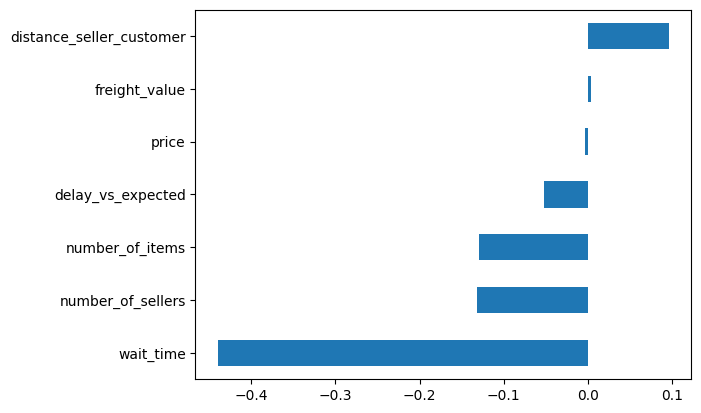

In [18]:
model4.params[1:].sort_values().plot(kind='barh');

## 3 - Model Performansını Kontrol Edin

⚠️ Regresyon performansı sadece R-squared'i ile ölçülmemelidir!

👀 Her zaman tahminlerin dağılımını, özellikle de kalıntıları görselleştirin.

❓ Kalıntıları hesaplayın.

Kalıntıların ortalamasının 0'a eşit olduğunu görmelisiniz (doğrusal regresyon yapılırken bunu her zaman doğrulayın)

In [19]:
predicted_review_score = model4.predict(orders_standardized)
residuals = predicted_review_score - orders_standardized.review_score

🧮 İlişkili RMSE'yi hesaplayın.

In [20]:
rmse = (residuals**2).mean()**0.5
rmse

1.1883154116821097

📊 `residuals`'ı bir histogramda çizin.

Text(0.5, 1.0, 'residuals density plot')

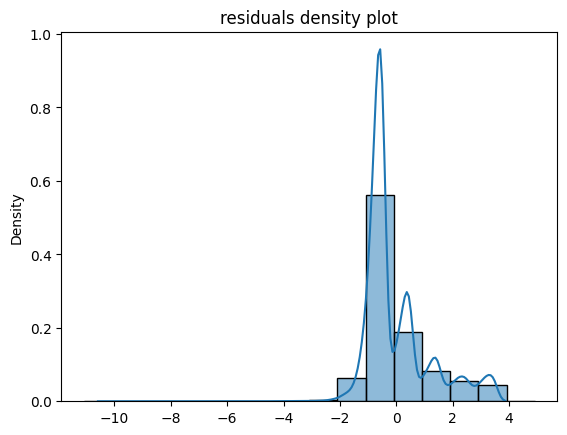

In [21]:
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot')

❓ Kalıntıların distplot'unun neden bu kadar garip bir şekle sahip olduğunu tahmin edebilir misiniz?

*İpucu:*<br/>
👉 Aynı grafik üzerinde hem `review_score`'un dağılımını hem de `predicted_review_score`'un dağılımını çizin.

Text(0.5, 1.0, 'distribution of predicted and actual values')

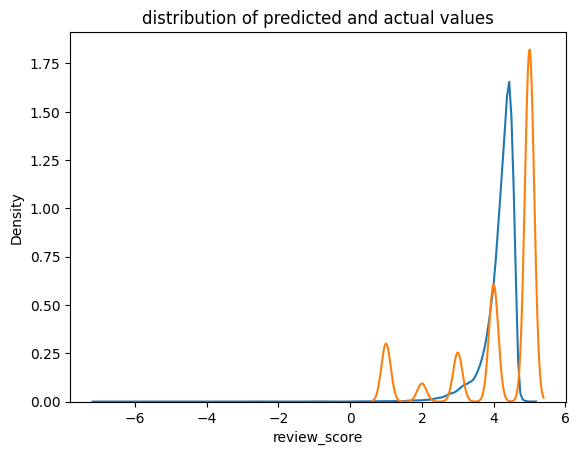

In [22]:
sns.kdeplot(predicted_review_score, label='predicted review score')
sns.kdeplot(orders.review_score, label='actual review score')
plt.title('distribution of predicted and actual values')

📈 Aslında, önceki zorlukta `review_score`'un `delay_vs_expected`'e karşı `regresyon çizgisi`'ni zaten çizmiştik.

Bu çizimi yeniden görselleştirmek için aşağıdaki hücreyi çalıştırın:

(0.0, 5.938719030441714)

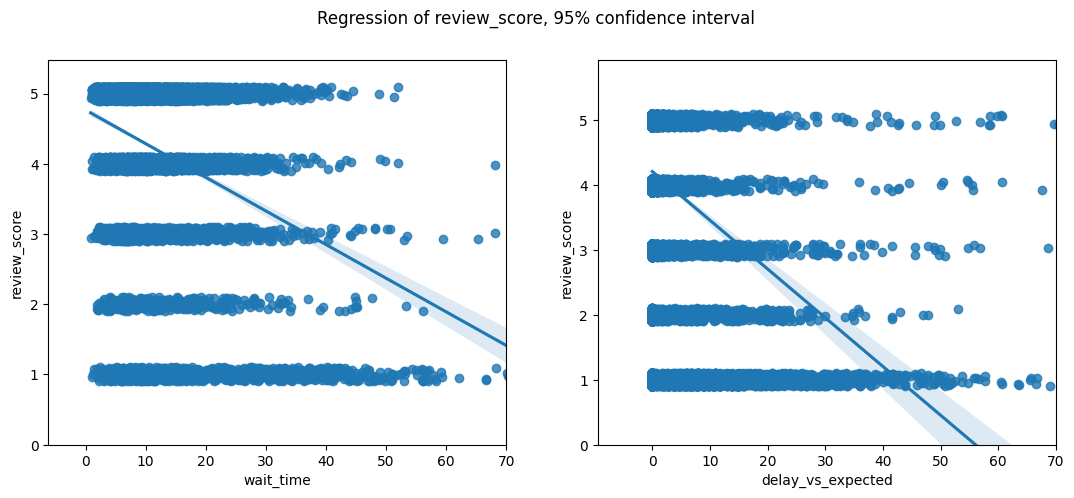

In [23]:
sample = orders.sample(10000, random_state=42)
plt.figure(figsize=(13,5))
plt.suptitle('Regression of review_score, 95% confidence interval')
plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = orders.delay_vs_expected, y= orders.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

☝️ Bir siparişin `review_score`'unu onun `wait_time` veya `delay_vs_expected`'ine karşı regrese etmenin zor olduğunu görebilirsiniz çünkü `review_score` ayrı bir sayı olup aynı zamanda bir kategori olarak da yorumlanabilir: 1 (çok kötü), 2 (kötü), 3 (orta), 4 (iyi), 5 (mükemmel).

📅 Sonraki ünitede, adına rağmen bir `Classification Algorithm` olan yeni bir model keşfedeceksiniz: `Logistic Regression` 

☝️ Sonuç olarak, modelimiz iki nedenden dolayı o kadar harika değil:
- İlk olarak, review_scores'un önemli bir kısmını açıklamak için yeterli özelliğimiz olmadığı için (düşük R-squared)
- İkinci olarak, "doğrusal regresyon" işlevini ayrı bir sınıflandırma problemine uydurmaya çalıştığımız için

💡 Bireysel siparişler üzerinde çalışmak ve `wait_time` tabanlı ayrı `review_score`'ları açıklamaya çalışmak yerine, bir sonraki zorlukta siparişleri satıcılar tarafından toplayarak analiz edilmesini satıcı seviyesine yoğunlaştıracağız.

🏁 Harika iş!

💾 İşiniz bittiğinde bu not defterini *kaydetmeyi*, *commit* ve *push* etmeyi unutmayın!